In [1]:
import time
import pandas as pd
from IPython.display import display_html
from matplotlib import pyplot as plt

## load image

In [2]:
import numpy as np
import os
import PIL
from PIL import Image, ImageOps
PIL.Image.MAX_IMAGE_PIXELS = 933120000

cached_img_load = {}

def get_files(name,path):
    if not os.path.isdir(path):
        return [(name,path)]
    else:
        targets = [
            f for f in os.listdir(path) if not os.path.isdir(os.path.join(path, f))
        ]
        return [
            (name + '/' + f, os.path.join(path, f)) for f in targets
        ]

def load_image(name,path):
    try:
        image = Image.open(path)
        # https://stackoverflow.com/questions/63947990/why-are-width-and-height-of-an-image-are-inverted-when-loading-using-pil-versus
        image = ImageOps.exif_transpose(image)

        img = np.array(image.convert('RGB'))
        dpi = image.info.get("dpi")

        print("name: ", name, 'dpi:', dpi)

        cached_img_load[name] = (img,dpi)
    except Exception as e:
        print("skip: ", path)

In [3]:
files = get_files("images", os.path.abspath("../images/dft-projection"))
for n,f in files:
    load_image(n,f)

name:  images/msqcnD0Mpz0CG0AizC0SqA.png dpi: None


## preprocess image

name:  images/msqcnD0Mpz0CG0AizC0SqA.png time:  0.001989 seconds


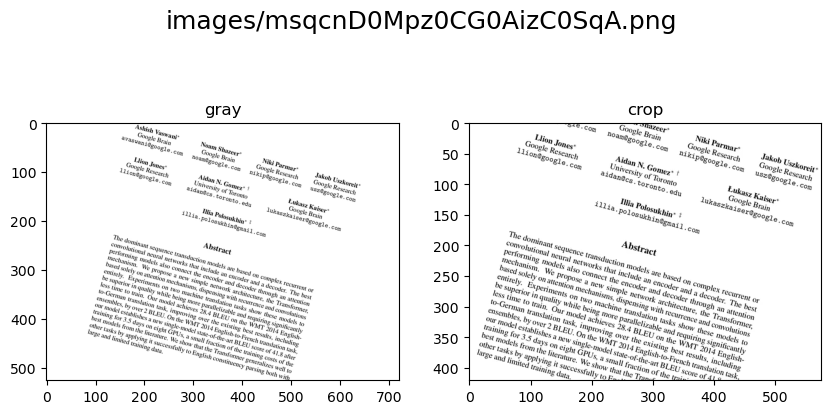

In [4]:
import cv2

cached_img_preprocess = {}

for name,(img,_) in cached_img_load.items():
    start = time.time()

    # grayed image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # trim the border to prevent interference
    height,width = gray.shape[:2]
    # define the cutting ratio to be retained.
    left_ratio = 0.1
    right_ratio = 0.1
    top_ratio = 0.1
    bottom_ratio = 0.1
    # cutting position
    left = int(width * left_ratio)
    right = int(width * (1 - right_ratio))
    top = int(height * top_ratio)
    bottom = int(height * (1 - bottom_ratio))
    # cropped image
    crop = gray[top:bottom, left:right]

    end = time.time()
    cached_img_preprocess[name] = crop


    print("name: ", name, "time: ", "{:.6f} seconds".format(end - start))

    # show the output image
    show_imgs = [
        ("gray", gray),
        ("crop", crop),
    ]
    show_count = len(show_imgs)
    fig = plt.figure(figsize=(show_count * 5,5))
    fig.suptitle(name, fontsize=18)
    gs = fig.add_gridspec(1,show_count)
    for idx, (name,img) in enumerate(show_imgs):
        if img is None: continue
        ax = fig.add_subplot(gs[0, idx])
        ax.set_title(name)
        ax.imshow(img, cmap='gray')

## dft magnitude

name:  images/msqcnD0Mpz0CG0AizC0SqA.png time: 0.019537 seconds


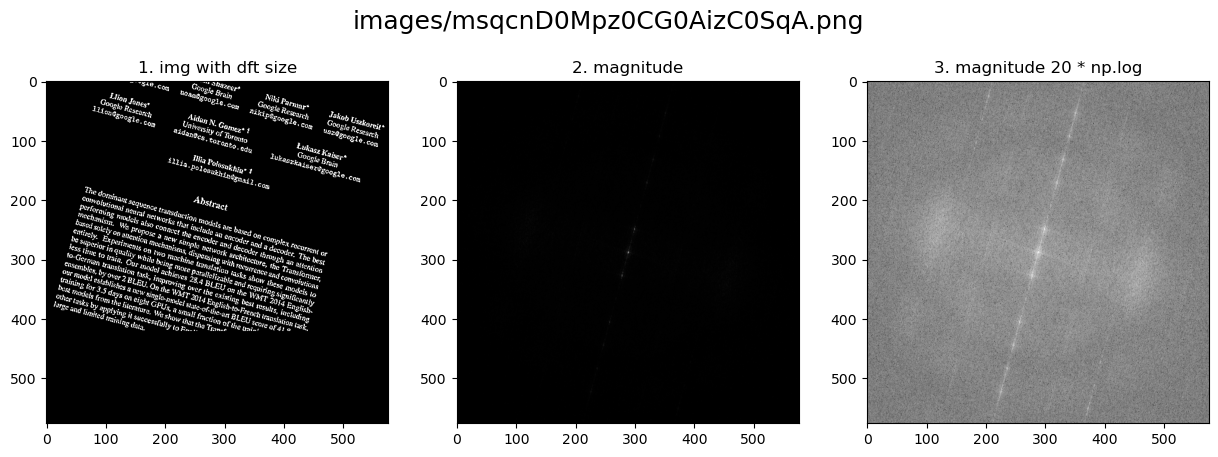

In [5]:
cached_dft_magnitude = {}

for name,img in cached_img_preprocess.items():
    start = time.time()

    nw = nh = cv2.getOptimalDFTSize(max(img.shape[:2]))
    output_image = cv2.copyMakeBorder(
        src=img,
        top=0,
        bottom=nh - img.shape[0],
        left=0,
        right=nw - img.shape[1],
        borderType=cv2.BORDER_CONSTANT,
        value=255,
    )

    # thresh
    opt_gray = cv2.adaptiveThreshold(
        ~output_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, -10
    )

    # perform fft
    dft = np.fft.fft2(opt_gray)
    shifted_dft = np.fft.fftshift(dft)

    # get the magnitude (module)
    magnitude = np.abs(shifted_dft)

    # same as 20 * np.log1p(magnitude)
    # dft2 = cv2.dft(np.float32(opt_gray), flags=cv2.DFT_COMPLEX_OUTPUT)
    # dft_shift = np.fft.fftshift(dft2)
    # magnitude_spectrum = 20 * np.log1p(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
    magnitude_spectrum = 20 * np.log1p(magnitude)

    end = time.time()
    cached_dft_magnitude[name] = (magnitude, magnitude_spectrum)


    print("name: ", name, "time:", "{:.6f} seconds".format(end - start))

    fig = plt.figure(figsize=(15,5))
    fig.suptitle(name, fontsize=18)
    gs = fig.add_gridspec(1,3)

    ax = fig.add_subplot(gs[0,0])
    ax.set_title(f"1. img with dft size")
    ax.imshow(opt_gray, cmap="gray")

    ax = fig.add_subplot(gs[0,1])
    ax.set_title(f"2. magnitude")
    ax.imshow(magnitude, cmap="gray")

    ax = fig.add_subplot(gs[0,2])
    ax.set_title(f"3. magnitude 20 * np.log")
    ax.imshow(magnitude_spectrum, cmap="gray")


## radial projection

name:  images/msqcnD0Mpz0CG0AizC0SqA.png time:  0.065180 seconds


,degree,sum
0,-90,22592478.820291
1,-89,29405202.455447
2,-88,29498304.683195
3,-87,29533175.158173
4,-86,30774261.731669
5,-85,30492128.616604
6,-84,31095843.336206
7,-83,29698739.109443
8,-82,30411674.684010
9,-81,31561463.551353


,angle degree,rotation degree
images/msqcnD0Mpz0CG0AizC0SqA.png,-15.586592,15.586592


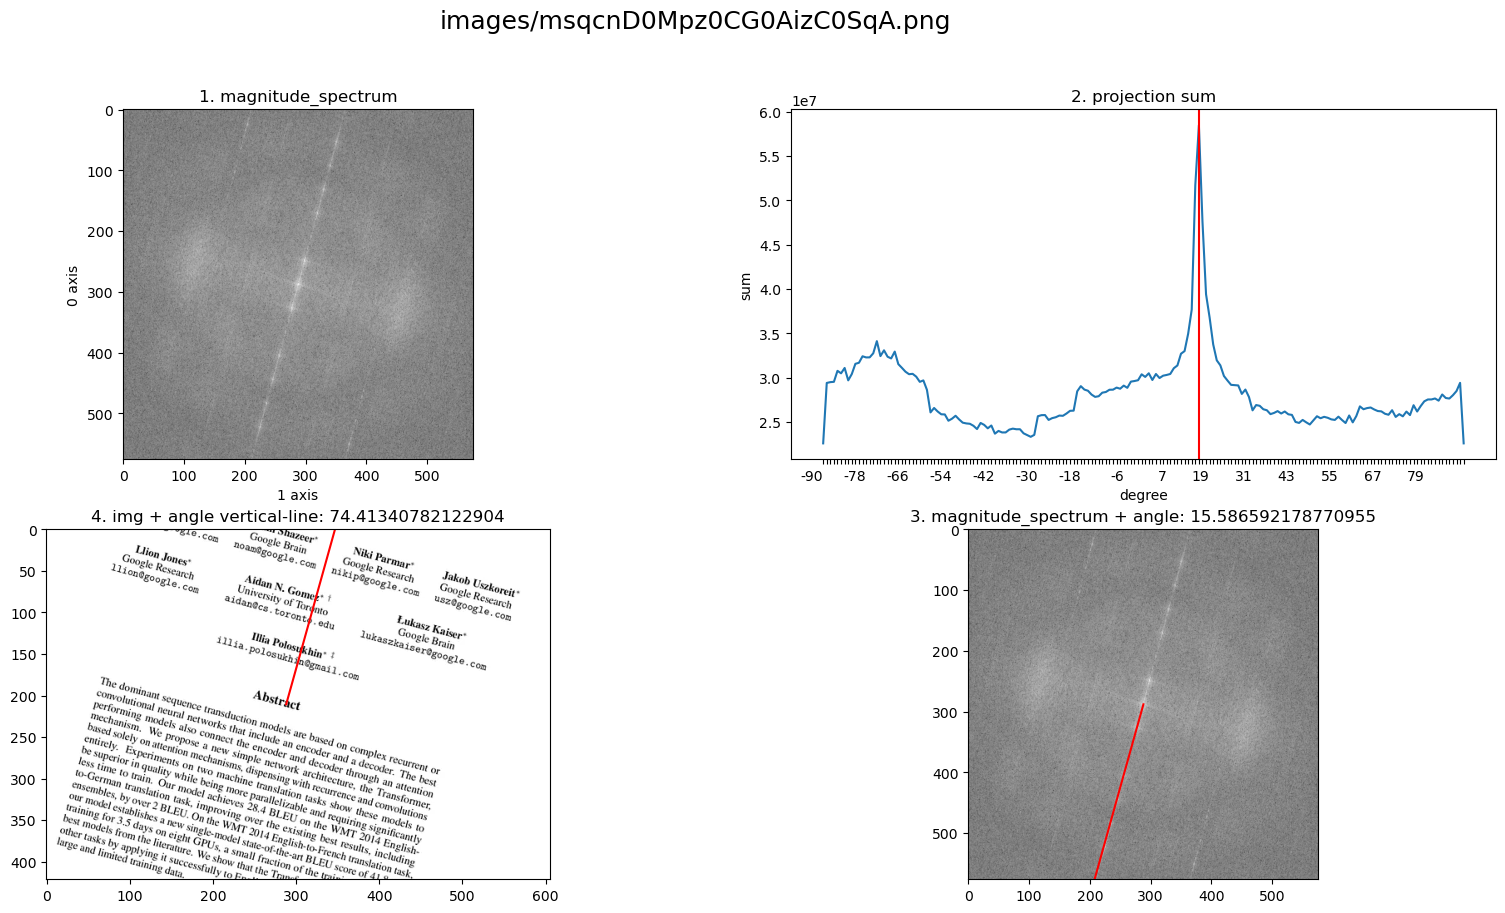

In [6]:
cached_angle_most = {}

for name,(magnitude,magnitude_spectrum) in cached_dft_magnitude.items():
    start = time.time()

    r = c = magnitude.shape[0] // 2

    # ±90 degrees with 1 step of each degree, will generate 180 vectors
    angle_max = 90
    num = 1

    tr = np.linspace(-1 * angle_max, angle_max, int(angle_max * num * 2)) / 180 * np.pi
    profile_arr = tr.copy()

    def f(t):
        _f = np.vectorize(
            lambda x: magnitude[c + int(x * np.cos(t)), c + int(-1 * x * np.sin(t))]
        )
        _l = _f(range(0, r))
        val_init = np.sum(_l)
        return val_init

    vf = np.vectorize(f)
    li = vf(profile_arr)

    a = tr[np.argmax(li)] / np.pi * 180

    if a == -1 * angle_max:
        a = 0


    # Image angle is the vertical-line of vertical-axis
    # When left-rotation 'a' degrees, vertical-line coincide with vertical-axis.
    # vertical-line of left-rotation relative to the image vertical-axis
    angle_deg_vline_vaxis = - a

    # to image vertical-axis right-rotation angle
    angle_deg_skew = angle_deg_vline_vaxis

    # convert image vertical-axis right-rotation angle to deskew angle
    rotation_deg_deskew = - angle_deg_skew

    end = time.time()
    cached_angle_most[name] = (angle_deg_skew, rotation_deg_deskew)


    print("name: ", name, "time: ", "{:.6f} seconds".format(end - start))

    df = pd.DataFrame.from_dict({
        'degree': range(-angle_max,angle_max),
        'sum': li
    }, orient='columns')
    styled_df = df.style.set_caption(f"sum: {name}")
    display(styled_df)

    fig = plt.figure(figsize=(20, 10))
    fig.suptitle(name, fontsize=18)
    gs = fig.add_gridspec(2, 2)

    ax = fig.add_subplot(gs[0, 0])
    ax.set_title(f"1. magnitude_spectrum")
    ax.set_ylabel("0 axis")
    ax.set_xlabel("1 axis")
    ax.imshow(magnitude_spectrum, cmap="gray", aspect='equal')

    # x labels use degree angles
    angles = tr / np.pi * 180
    visible_count = len(angles) // 15
    visible_labels = [f'{angle:.0f}' if i % visible_count == 0 else '' for i, angle in enumerate(angles)]
    # max sum x axis index
    max_idx = np.argmax(li)

    ax = fig.add_subplot(gs[0, 1], aspect='auto')
    ax.set_title("2. projection sum")
    ax.set_xticks(np.arange(len(angles)))
    ax.set_xticklabels(visible_labels, ha='right')
    ax.set_xlabel("degree")
    ax.set_ylabel("sum")
    ax.plot(li)
    ax.axvline(max_idx, color='r')

    # range 0 - 180
    angle_deg_vline_haxis = angle_deg_vline_vaxis + 90
    xc = c
    yc = c
    x2 = c * 2
    y2 = c
    # image axis angle to x-y axis
    angle_rag_vline_haxis = np.deg2rad(-angle_deg_vline_haxis)
    b = x2 - xc
    a = b / np.cos(angle_rag_vline_haxis) * np.sin(angle_rag_vline_haxis)
    # only draw the bottom part
    if a < 0:
        a = -a
        x2 = 0
    y2 = yc + a

    ax = fig.add_subplot(gs[1, 1], aspect='auto')
    ax.set_title(f"3. magnitude_spectrum + angle: {-angle_deg_vline_vaxis}")
    ax.set_ylim(magnitude_spectrum.shape[0], 0)
    ax.set_xlim(0, magnitude_spectrum.shape[1])
    ax.imshow(magnitude_spectrum, cmap="gray", aspect='equal')
    ax.plot((xc, x2), (yc, y2), '-', color='r')

    img = cached_img_preprocess[name]
    xc = img.shape[1] / 2
    yc = img.shape[0] / 2
    x2 = img.shape[1]
    y2 = img.shape[0] / 2
    # image axis angle to x-y axis
    angle_rag_vline_haxis = np.deg2rad(-angle_deg_vline_haxis)
    b = x2 - xc
    a = b / np.cos(angle_rag_vline_haxis) * np.sin(angle_rag_vline_haxis)
    # only draw the top part
    if a > 0:
        a = -a
        x2 = 0
    y2 = yc + a

    ax = fig.add_subplot(gs[1, 0])
    ax.set_title(f"4. img + angle vertical-line: {angle_deg_vline_haxis}")
    ax.set_ylim(img.shape[0], 0)
    ax.imshow(img, cmap="gray", aspect='equal')
    ax.plot((xc, x2), (yc, y2), '-', color='r')

df = pd.DataFrame.from_dict(cached_angle_most, orient='index', columns=['angle degree', 'rotation degree'])
display(df)

## deskew image

name:  images/msqcnD0Mpz0CG0AizC0SqA.png time:  0.001000 seconds


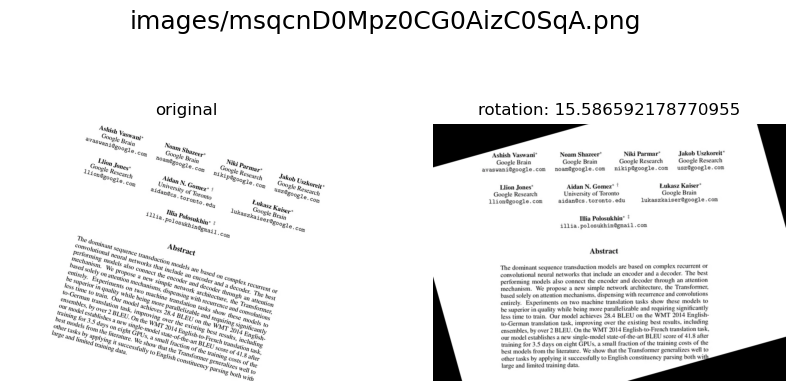

In [7]:
for name,(angle_deg,rotation_deg) in cached_angle_most.items():
    start = time.time()

    img,_ = cached_img_load[name]

    # Rotate original image
    img_center = tuple(np.array(img.shape[1::-1]) / 2)
    rotation_matrix = cv2.getRotationMatrix2D(img_center, rotation_deg, 1.0)
    img_rotated = cv2.warpAffine(img, rotation_matrix, img.shape[1::-1], flags=cv2.INTER_LINEAR)

    end = time.time()


    print("name: ", name, "time: ", "{:.6f} seconds".format(end - start))

    # show the output image
    imgs_show = [
        ("original", img),
        (f"rotation: {rotation_deg}", img_rotated)
    ]
    fig = plt.figure(figsize=(10,5))
    fig.suptitle(name, fontsize=18)
    gs = fig.add_gridspec(1,len(imgs_show))
    for idx, (name,img) in enumerate(imgs_show):
        ax = fig.add_subplot(gs[0, idx])
        ax.set_title(name)
        ax.axis('off')
        ax.imshow(img)
